<a href="https://colab.research.google.com/github/LukeAndrewSmith/DM_Project/blob/master/DM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Reading and Cleaning
=========================

## Helpers

In [0]:
# Pretty print helpers
def print_section(title):
    print()
    print('=' * (len(title) + 4))
    print(' ', title)
    print('=' * (len(title) + 4))

def print_subsection(title):
    print('-' * (len(title) + 4))
    print(' ', title)
    print('-' * (len(title) + 4))

# Array diff
def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

Beijing
-------


### Importing the data
We will begin by importing the csv files into pandas dataframes, a data type that can greatly simplify the process of data cleansing.

We also print out the time taken to read the csv files.

Note that we converted the Beijing_AirQuality_Stations_en.xls file to a csv, removing the unnecessary info.


In [61]:
import pandas as pd
import numpy as np
from timeit import default_timer as timer

# Ensure pandas outputs all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

def get_dataframe(filename):
    df = pd.read_csv(filename)
    return df

if 'aq_1' in globals():
  del aq_1
if 'aq_2' in globals():
  del aq_2
if 'meo_1' in globals():
  del meo_1
if 'meo_2' in globals():
  del meo_2
if 'meo_3' in globals():
  del meo_3
if 'aq_stations' in globals():
  del aq_stations

start = timer()
aq_1 = get_dataframe('beijing_17_18_aq.csv')
aq_2 = get_dataframe('beijing_201802_201803_aq.csv')
meo_1 = get_dataframe('beijing_17_18_meo.csv')
meo_2 = get_dataframe('beijing_201802_201803_me.csv')
meo_3 = get_dataframe('Beijing_historical_meo_grid.csv')
aq_stations = get_dataframe('Beijing_AirQuality_Stations_en.csv')
end = timer()

print_section('Time')
print(end - start)



  Time
0.9383515240006091


### Initial look at the data
We will print the heads of the **DataFrames** to get an idea of the information each csv can provided.\
We will also find the max/min times to check that the date ranges between the AQ and MEO data correspond.

In [62]:
## AQ
print_section('beijing_17_18_aq.csv')
print_subsection('head')
print(aq_1.head(1))
print_subsection('utc_time')
print('Min:', aq_1.utc_time.min())
print('Max:', aq_1.utc_time.max())

print_section('beijing_201802_201803_aq.csv')
print_subsection('head')
print(aq_2.head(1))
print_subsection('utc_time')
print('Min:', aq_2.utc_time.min())
print('Max:', aq_2.utc_time.max())

## MEO
print_section('beijing_17_18_meo.csv')
print_subsection('head')
print(meo_1.head(1))
print_subsection('utc_time')
print('Min:', meo_1.utc_time.min())
print('Max:', meo_1.utc_time.max())

print_section('beijing_201802_201803_me.csv')
print_subsection('head')
print(meo_2.head(1))
print_subsection('utc_time')
print('Min:', meo_2.utc_time.min())
print('Max:', meo_2.utc_time.max())

print_section('Beijing_historical_meo_grid.csv')
print_subsection('head')
print(meo_3.head(1))

# Check that the features of meo_1 and meo_2 correspond
print_section('Diff meo_1 meo_2')
print_subsection('Features')
print(diff(meo_1.columns, meo_2.columns))
print(diff(meo_2.columns, meo_1.columns))


  beijing_17_18_aq.csv
--------
  head
--------
         stationId             utc_time  PM2.5   PM10    NO2   CO   O3  SO2
0  aotizhongxin_aq  2017-01-01 14:00:00  453.0  467.0  156.0  7.2  3.0  9.0
------------
  utc_time
------------
Min: 2017-01-01 14:00:00
Max: 2018-01-31 15:00:00

  beijing_201802_201803_aq.csv
--------
  head
--------
         stationId             utc_time  PM2.5  PM10   NO2   CO   O3   SO2
0  aotizhongxin_aq  2018-01-31 16:00:00   49.0  82.0  90.0  0.9  6.0  10.0
------------
  utc_time
------------
Min: 2018-01-31 16:00:00
Max: 2018-03-31 15:00:00

  beijing_17_18_meo.csv
--------
  head
--------
   station_id   longitude   latitude             utc_time  temperature  pressure  humidity  wind_direction  wind_speed      weather
0  shunyi_meo  116.615278  40.126667  2017-01-30 16:00:00         -1.7    1028.7        15           215.0         1.6  Sunny/clear
------------
  utc_time
------------
Min: 2017-01-30 16:00:00
Max: 2018-01-31 15:00:00

  beijing_201802

### Observations
Above we can see that the files
beijing_17_18_aq.csv and beijing_201802_201803_aq.csv
contain all the necessary info for the air quality and the files 
beijing_17_18_meo.csv and beijing_201802_201803_me.csv
contain all the necessary info for the meteorological data.

The file Beijing_historical_meo_grid.csv contains grid data for a smaller time period and does not correspond directly with the AQ data. \
**Decision** \
We could use the Data to help interpolate the missing values in the MEO datasets but we will not as we don't have the time.

We can also see that 
beijing_17_18_meo.csv
begins on 2017-01-30 rather than 2017-01-01 like for the AQ data sets, and so we will need to drop the first 30 days from the AQ data sets or add nans and interpolate.
**Decision** \
We will add nans and interpolate.

### Cleaning and merging the data

####Get all utc_times

In [94]:
# Each station should have the following datetimes
# times = [2017-01-01 00:00:00, ... , 2018-03-20 23:00:00]

from datetime import timedelta, date, datetime

def daterange(date1, date2):
    for m in range(int ((date2 - date1).days)+1):
        for n in range(24):
            yield date1 + timedelta(days=m,hours=n)

start_dt = datetime(2017, 1, 1, 0, 0, 0)
end_dt = datetime(2018, 3, 22, 23, 0, 0)
ran = daterange(start_dt, end_dt)
times = [r.strftime("%Y-%m-%d %H:%M:%S") for r in ran]
print(times[0:3])
print(times[-3:])


['2017-01-01 00:00:00', '2017-01-01 01:00:00', '2017-01-01 02:00:00']
['2018-03-22 21:00:00', '2018-03-22 22:00:00', '2018-03-22 23:00:00']


####AQ fill in missing utc_time + interpolate + plot


  Missing AQ
----------------------
  Rows to add format
----------------------
[{'utc_time': '2017-01-01 01:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01-01 02:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01-01 03:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01-01 04:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01-01 05:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01-01 06:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01-01 07:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01-01 08:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01-01 09:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01-01 10:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01-01 11:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01-01 12:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01-01 13:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01

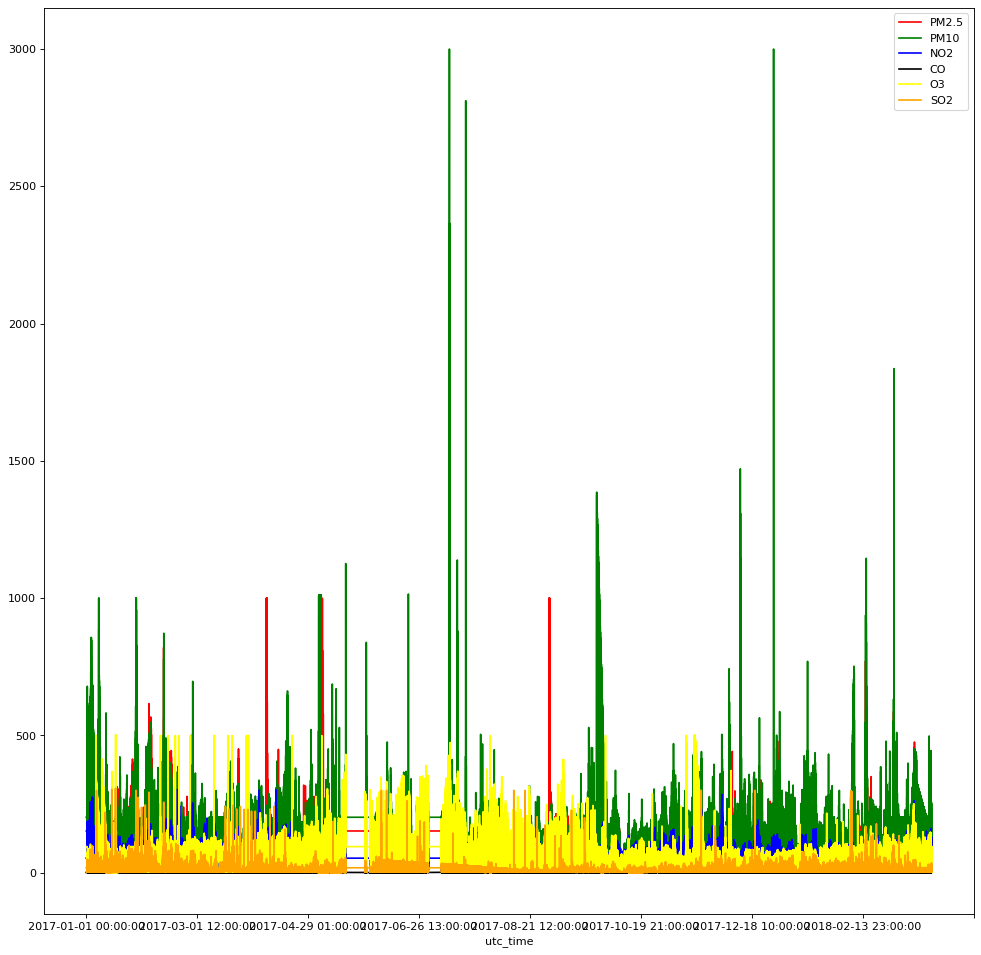

In [95]:
# AQ Merge Tables

# Concat
aq = aq_1.append(aq_2)

#### DECISION ####
# Not all the required hours/days (utc_time's) are presents
# We will add NaNs for missing utc_time's and they will be filled in with the interpolation below
print_section('Missing AQ')
missing_aq = []
for id in aq.stationId.unique():
    dates_id = aq[aq.stationId == id].utc_time
    missing_dates_id = diff(times, dates_id)
    for date in missing_dates_id:
        missing_aq.append({'utc_time': date, 'stationId': id})

print_subsection('Rows to add format')
print(missing_aq[1:20])

print_subsection('Shapes before/after add')
print(aq.shape[0])
aq = aq.append(missing_aq, ignore_index=True)
print(aq.shape[0])

print_subsection('Verify all dates')
print('Check diff between expected times and actual for each station, should be an array of zeros')
len_check = []
for id in aq.stationId.unique():
    len_check.append(len(diff(times, aq[aq.stationId == id]['utc_time'].unique())))
print(len_check)

#### DECISION ####
# Interpolate before separating the test/train data, IS THIS WRONG?????
# TODO: Interpolate the stations separately????????????????????????
# Interpolate missing values
aq.interpolate(method='linear', inplace=True)

# Keep only up till 2018-03-22
aq = aq[aq.utc_time < '2018-03-23']
# Make sure stations are sorted alphabetically
aq = aq.sort_values(['utc_time', 'stationId'])

# Plots
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')

ax = plt.gca()
aq.plot(kind='line',x='utc_time',y='PM2.5', color='red', ax=ax)
aq.plot(kind='line',x='utc_time',y='PM10', color='green', ax=ax)
aq.plot(kind='line',x='utc_time',y='NO2', color='blue', ax=ax)
aq.plot(kind='line',x='utc_time',y='CO', color='black', ax=ax)
aq.plot(kind='line',x='utc_time',y='O3', color='yellow', ax=ax)
aq.plot(kind='line',x='utc_time',y='SO2', color='orange', ax=ax)
plt.show()

####MEO fill in missing utc_time + interpolate + plot


  Missing MEO
----------------------
  Rows to add format
----------------------
[{'utc_time': '2017-01-01 01:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 02:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 03:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 04:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 05:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 06:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 07:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 08:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 09:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 10:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 11:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 12:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 13:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 14:00:00', 'station_id': 'shunyi_meo'}, {'utc_t

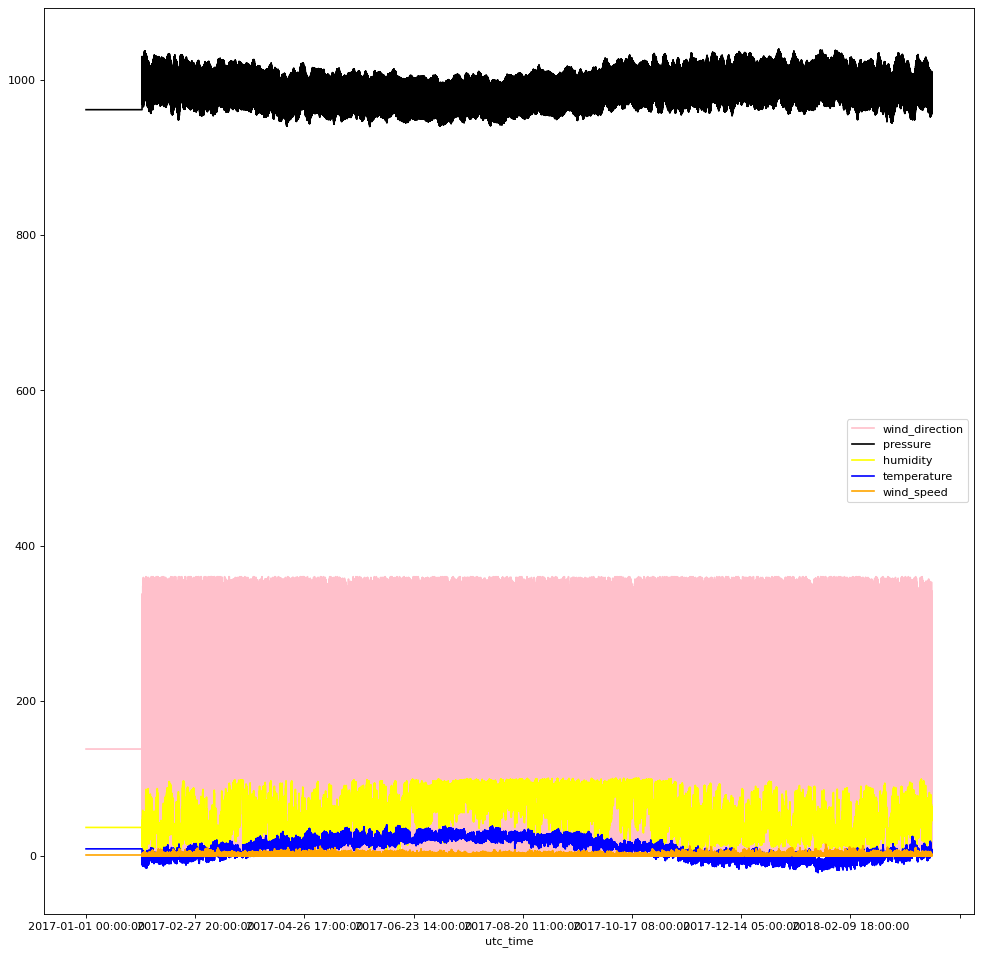

In [96]:
#MEO MERGE

#### DECISION ####
# Replace invalid wind_direction's by nan
meo_1 = meo_1.replace(meo_1[meo_1.wind_direction > 360]['wind_direction'].unique(), np.nan)
meo_2 = meo_2.replace(meo_2[meo_2.wind_direction > 360]['wind_direction'].unique(), np.nan)

#### DECISION ####
# Replace invalid humidities's by nan
meo_1 = meo_1.replace(meo_1[meo_1.humidity > 100]['humidity'].unique(), np.nan)
meo_2 = meo_2.replace(meo_2[meo_2.humidity > 100]['humidity'].unique(), np.nan)

#### DECISION ####
# TODO: Maybe get data from grid before interpolating (need long/lat)
# Decision: Don't take data from grid, don't have time 

# Drop lat/long, would be used if we fetched data from the grid before interpolating
if 'latitude' in meo_1:
    meo_1 = meo_1.drop(['latitude', 'longitude'], axis=1) # Drop unused columns

# Concat
meo = meo_1.append(meo_2)

#### DECISION ####
# Not all the required hours/days (utc_time's) are presents
# We will add NaNs for missing utc_time's and they will be filled in with the interpolation below
print_section('Missing MEO')
missing_meo = []
for id in meo.station_id.unique():
    dates_id = meo[meo.station_id == id].utc_time
    missing_dates_id = diff(times, dates_id)
    for date in missing_dates_id:
        missing_meo.append({'utc_time': date, 'station_id': id})

print_subsection('Rows to add format')
print(missing_meo[1:20])

print_subsection('Shapes before/after add')
print_subsection
print(meo.shape[0])
meo = meo.append(missing_meo, ignore_index=True)
print(meo.shape[0])

print_subsection('Verify all dates')
print('Check diff between expected times and actual for each station, should be an array of zeros')
len_check = []
for id in meo.station_id.unique():
    len_check.append(len(diff(times, meo[meo.station_id == id]['utc_time'].unique())))
print(len_check)


#### DECISION ####
# Interpolate before separating the test/train data, IS THIS WRONG?????
# TODO: Interpolate the stations separately????????????????????????
# Interpolate missing values
meo.interpolate(method='linear', inplace=True)

# Keep only up till 2018-03-22
meo = meo[meo.utc_time < '2018-03-23']
# Make sure stations are sorted alphabetically
meo = meo.sort_values(['utc_time', 'station_id'])


# Plots
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')

ax = plt.gca()
meo.plot(kind='line',x='utc_time',y='wind_direction', color='pink', ax=ax)
meo.plot(kind='line',x='utc_time',y='pressure', color='black', ax=ax)
meo.plot(kind='line',x='utc_time',y='humidity', color='yellow', ax=ax)
meo.plot(kind='line',x='utc_time',y='temperature', color='blue', ax=ax)
meo.plot(kind='line',x='utc_time',y='wind_speed', color='orange', ax=ax)
plt.show()

####Feature Extraction

####AQ+MEO Concat 

In [100]:
# AQ concat
if not aq.index.name == 'utc_time':
    aq = aq.set_index(['utc_time'])
# Add all info for a given utc_time to one column
aq_concat = aq[aq.stationId == aq.stationId.unique()[0]]
stations = aq.stationId.unique()[1:]
for station in stations:
    aq_concat = pd.concat([aq_concat,aq[aq.stationId == station]], axis=1)
#### DECISION ####
# Remove duplicate utc_time's
# Keep values from the first index instance
aq_concat = aq_concat.loc[~aq_concat.index.duplicated(keep='first')] 
print(aq_concat.index.is_unique)
# print(aq_concat)


# MEO concat
if not meo.index.name == 'utc_time':
    meo = meo.set_index(['utc_time'])
# Add all info for a given utc_time to one column
meo_concat = meo[meo.station_id == meo.station_id.unique()[0]]
stations = meo.station_id.unique()[1:]
for station in stations:
    meo_concat = pd.concat([meo_concat,meo[meo.station_id == station]], axis=1)
#### DECISION ####
# Remove duplicate utc_time's
# Keep values from the first index instance
meo_concat = meo_concat.loc[~meo_concat.index.duplicated(keep='first')] 
print(meo_concat.index.is_unique)
# print(meo_concat)

# AQ + MEO
data = pd.concat([aq_concat,meo_concat], axis=1)
# print(data)
data.drop(['stationId', 'station_id', 'weather'], axis=1, inplace=True) # TODO: Don't drop weather, convert to numeric
print(data)




True
True
                     PM2.5   PM10    NO2   CO    O3   SO2  PM2.5   PM10   NO2   CO    O3   SO2  PM2.5   PM10   NO2   CO    O3   SO2  PM2.5   PM10   NO2   CO    O3   SO2  PM2.5   PM10   NO2   CO  \
utc_time                                                                                                                                                                                            
2017-01-01 00:00:00  152.0  202.0   53.0  1.0  95.0  18.0  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.0  53.0  1.0   
2017-01-01 01:00:00  152.0  202.0   53.0  1.0  95.0  18.0  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.0  53.0  1.0   
2017-01-01 02:00:00  152.0  202.0   53.0  1.0  95.0  18.0  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.0  53.0  1.0   
2017-

####Create data

In [98]:
def history(h,df):
    dfHist = df.copy()
    utc_times = df.index.values

    for i in range(1,h+1):
        shifted = np.roll(utc_times, -i)
        toConcat = df.copy().reset_index()
        toConcat.utc_time = shifted
        toConcat = toConcat.set_index('utc_time')
        dfHist = pd.concat([dfHist, toConcat], axis=1)

    dfHist.drop(dfHist.index[:h], inplace=True)   # First h values can't have h history values
    dfHist.drop(dfHist.index[-1:], inplace=True)  # Last value can't have a y value associated
    return dfHist 

# df1 = pd.DataFrame([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]], columns=['utc_time','B']).set_index('utc_time')
# print(df1)
# print(history(3,df1))

# start = timer()
# t = history(3,aq_concat)
# end = timer()
# print(t)
# print_section('Time')
# print(end - start)

def x_y_split(h,df):
    X = history(h,df)
    y = df.copy()
    y.drop(y.index[:h+1], inplace=True)
    return X,y

# X,y = x_y_split(3,aq_concat)
# print(diff(y.index.values, X.index.values))


# 
# X_train -> Y_train
# 1 -> 2
# 2 -> 3
# 3 -> 4
# 4 -> 5
# 5 -> 6

def test_train_split(h,df):
    X,y = x_y_split(h,df)
    X_train = X[X.index < '2018-03-21']
    X_train = X_train[:-1]
    y_train = y[y.index < '2018-03-21']
    X_test = X[X.index > '2018-03-21']
    y_test = y[y.index > '2018-03-21']
    y_test = y_test[1:]
    return X_train, y_train, X_test, y_test
    
X_train, y_train, X_test, y_test = test_train_split(3,data)

print(X_train)

# Check correctness
print(diff(X_train.index.values, y_train.index.values))
print(diff(y_train.index.values, X_train.index.values))
print(diff(X_test.index.values, y_test.index.values))
print(diff(y_test.index.values, X_test.index.values))


                     PM2.5   PM10   NO2   CO    O3   SO2  PM2.5   PM10   NO2   CO    O3   SO2  PM2.5   PM10   NO2   CO    O3   SO2  PM2.5   PM10   NO2   CO    O3   SO2  PM2.5        PM10   NO2   CO  \
2017-01-01 03:00:00  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.000000  53.0  1.0   
2017-01-01 04:00:00  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.000000  53.0  1.0   
2017-01-01 05:00:00  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.000000  53.0  1.0   
2017-01-01 06:00:00  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.0  53.0  1.0  95.0  18.0  152.0  202.000000  53.0  1.

### Model Training

#### Dummy Classifier


We'll be using https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html

In [99]:
from sklearn.dummy import DummyRegressor
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
# dummy_regr.predict(X_train)
dummy_regr.score(X_train, y_train)
dummy_regr.score(X_test, y_test)

ValueError: ignored

#### Linear Regression

In [0]:
# RANDOM LINEAR REGRESSION ATTEMPT
from sklearn.model_selection import train_test_split


# import the relevant module for back...
import statsmodels.api as sm

# separate our my predictor variables (X) from my outcome variable y
X = df2[predictors]
y = df2['meantempm']

# # Add a constant to the predictor variable set to represent the Bo intercept
# X = sm.add_constant(X)
# X.ix[:5, :5]




# first remove the const column because unlike statsmodels, SciKit-Learn will add that in for us
X = X.drop('const', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)



from sklearn.linear_model import LinearRegression

# instantiate the regressor class
regressor = LinearRegression()

# fit the build the model by fitting the regressor to the training data
regressor.fit(X_train, y_train)

# make a prediction set using the test set
prediction = regressor.predict(X_test)

# Evaluate the prediction accuracy of the model
from sklearn.metrics import mean_absolute_error, median_absolute_error
print("The Explained Variance: %.2f" % regressor.score(X_test, y_test))
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error(y_test, prediction))
print("The Median Absolute Error: %.2f degrees celsius" % median_absolute_error(y_test, prediction))